Last updated: Feb 26, 2021<br>
Redoing code so it uses the ASC from Ecospace as basemap for transition matrix / interpolation
To do:<br>
Next - review what a transition matrix is (Etten, 2014, section 4) and what values
are needed in the cost raster. 
https://gis.stackexchange.com/questions/280593/understanding-the-values-from-transition-layers-produced-by-the-r-package-gdist
Generate voronoi using marine cells from Ecospace SHP <br>
Find nearest marine cell for each haulout (need code in R for spatial join)<br>
    

### Relative Foraging Intensity using Inverse Path Distance from Seal Haulout Counts 
input: Olesiuk et al's (2010) and subsequent seal haulout survey data downloaded from DFO's online portal <br>
output: GeoTiffs of seal distribution based on distance to haulouts <br>
created: Oct 2019 - Feb 2021<br>
author: G Oldford <br>
based on: gdistance in R by Etten (2014)

#### Purpose: 
- Calculate on-water (non-euclidean) paths from seal haulouts to surrounding marine areas. 
- Use cost-path surface to calculate inverse path distance weighting to do this (instead of euclidean) for each cell based on actual distance to haulout, respecting topographical barriers. 
- Sum and rescale scores for each cell for each haulout. Resulting map layer values sum to one (markov matrix) and can be used to distribute total regional seal biomass from other models or surveys. 
- To be used in representing distribution as spatial-temporal 'habitat' layers in Ecospace. 
 
#### General Steps: 
1) Import haulout locations and fix issues with the locations (e.g., erroneous lat / lons) <br>
2) Wrangle the haulout data by interpolating between years, fix multiple surveys per year by taking mean <br>
3) Import bathymetry and recode to use as a 'cost' layer <br>
4) Ensure the map projections are correct so the haulout points and cost layer actually overlap <br>
5) Main code loop <br>
 - creates a travel 'cost' raster layer for each haulout
 - converts the 'cost' to an inverse on-the-water distance grid
 - rescale the grid cell values to sum to 1 for each haulout
 - use the estimated seal abundance at each haulout as measure of relative haulout size to weight the grid cell values
 - sum all haulout rasters using a 'map algebra' approach
 - rescale the grid cell values to 1 in the final raster
 - use the resulting raster with annual regional abundance estimates to distribute seals spatially in Ecospace
 
 #### to do: 
 - add in haulout time series for san juan islands (Jeffries et al)
 - completed: if haulout landlocked, causes issues... need manual edits to haulout locations
 - completed: some years a single haulout was surveyed twice? Need to take mean.
 - completed: surveys done sporadically - need to interpolate each haulout between survey years to fill in missing years
 - completed: surveys were done for regions annually and so the whole dataset can't be interpolated at once, it has to be for each region - or the data need to be interpolated so there is a haulout estimate each year for each haulout, rather than gaps. See table in write-up. 
 - run for all years
 - completed: decide whether to output NAs instead of zeros
 
 ## TOC: <a class="anchor" id="top"></a>
* [1. Read haulout locations, fix issues](#section-1)
* [2. Spatial projections](#section-2)
    * [2a).](#section-2a)
    * [2b). ](#section-2b)
        * [2b)i.](#section-2bi)
        * [2b)ii.](#section-2bii)
* [3. Interpolation](#section-3)
    
* [4. ](#section-4)
* [Crosschecks and experiments](#section-5)

In [ ]:
# to install r packages from notebook
#install.packages("magick", repos='http://cran.us.r-project.org')

In [10]:
library(ipdw) # library for inverse path distance weighting
#https://github.com/jsta/ipdw/blob/master/R/pathdistGen.R

library(rgdal)
library(raster)
library(sp)
library(ncdf4)
library(sf) # reads CSV as 'simple features' (spatial)
library(ggplot2) # visualize
library(rnaturalearth)
library(rnaturalearthdata)
library(dplyr)
library(zoom)
library(zoo) #for na.approx
library(dplyr)
library(tidyverse)
# to do: the 'janitor' library may make cleaning data far easier

In [20]:
hl_df <- read.csv("C:/Users/Greig/Sync/6. SSMSP Model/Model Greig/Data/2. Seals/AbundanceLocations_Olesiuketal/MODIFIED/Harbour_Seal_Counts_from_Strait_of_Georgia_Haulout_Locations.csv")
#hl_pts <- st_read("../AbundanceLocations_Olesiuketal/MODIFIED/Harbour_Seal_Counts_from_Strait_of_Georgia_Haulout_Locations.csv", options=c("X_POSSIBLE_NAMES=Longitude","Y_POSSIBLE_NAMES=Latitude"))

# bathy file for travel cost layer
ncpath <- "../../NEMO-Salish-Sea-2021/data/bathymetry/"
#ncname <- "Bathymetry_1km"
ncname <- "bathy_salishsea_1500m_20210208"
dname <- "bathymetry"

### 1) Read haulout locations file and fix issues
 <a class="anchor" id="section-1"></a>
[BACK TO TOP](#top)

#### Fix issues with haulout data for non-survey years and years with multiple surveys

In [21]:
# Note that hl_df is not actually interpreted as a data frame by R, rather a 'list'
# this is why the 'length' method doesn't work unless converted to df

# make into 'tibble' - easier to work with in R (tidyverse)
#https://www.datanovia.com/en/lessons/identify-and-remove-duplicate-data-in-r/
hl_df_tib <- as_tibble(hl_df)
typeof(hl_df_tib)

# to convert the 'count' from a factor to dbl given a 'list'
hl_df_tib["Count"] <- as.numeric(as.character(unlist(hl_df_tib[["Count"]])))

# get only duplicates
hl_df_grouped <- hl_df_tib %>% group_by(Site.Key, Date.1) %>%
   filter(n()>1) 

# calculate the mean of duplicates
# https://stackoverflow.com/questions/46661461/calculate-mean-by-group-using-dplyr-package
hl_df_dupemean <- hl_df_grouped %>%
   dplyr::summarize(Mean = mean(Count, na.rm=TRUE))

# replace the 'count' for with the mean for certain sites with multiple surveys in a year
# exclude records with duplicate year/site key combo (keeps first record of duplicate)
hl_df_tibDistinct <- hl_df_tib %>% distinct(Date.1, Site.Key, .keep_all = TRUE)

# replaces count for duplicates with the mean value
hl_df_tibFixed <- hl_df_tibDistinct %>% 
  left_join(hl_df_dupemean, by = c("Site.Key","Date.1")) %>% 
  mutate(Count = ifelse(!is.na(Mean),Mean,Count))
  #filter(!is.na(Mean))

hl_df_tibFixed

[1] "list"

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

Site.Key,Location.Value,Location.Info,Latitude,Longitude,Date,Count,Date.1
<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<int>
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1973-06-13,1,1973
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1974-08-14,13,1974
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1976-08-12,35,1976
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1982-08-16,54,1982
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1986-08-16,94,1986
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1988-05-31,100,1988
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1988-08-12,189,1988
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1988-10-12,30,1988
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1989-03-08,23,1989


`summarise()` regrouping output by 'Site.Key' (override with `.groups` argument)


Site.Key,Location.Value,Location.Info,Latitude,Longitude,Date,Count,Date.1,Mean
<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<int>,<dbl>
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1973-06-13,1.0000,1973,NA
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1974-08-14,13.0000,1974,NA
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1976-08-12,35.0000,1976,NA
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1982-08-16,54.0000,1982,NA
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1986-08-16,94.0000,1986,NA
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1988-05-31,106.3333,1988,106.3333
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1989-03-08,23.0000,1989,NA
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1990-08-07,174.0000,1990,NA
H0001,West Bentinck Island Reefs,South Gulf,48.3125,-123.5499,1994-08-21,76.0000,1994,NA


#### Interpolate values between survey years for site

In [22]:
#https://stackoverflow.com/questions/43501670/complete-column-with-group-by-and-complete/43501854
all_years <- as_tibble(data.frame("Date.1" = as.integer(c(1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018))))

# insert years / surveys for years in which there were no surveys
hl_df_tibFixExtraYears <- all_years %>% left_join(hl_df_tibFixed, by = c("Date.1")) 
hl_df_tibFixExtraYears

hl_df_expandsurveys <- hl_df_tibFixExtraYears %>% 
    group_by(Date.1,Site.Key) %>% 
    summarise(count_number = n()) %>%
    ungroup() %>%
    complete(Date.1,Site.Key, fill = list(count_number = 1)) %>%
    left_join(hl_df_tibFixExtraYears, by = c("Site.Key","Date.1")) 

# inspect one site - should have empty records for missing years
hl_df_expandsurveys %>% filter(Site.Key == "H0069")

SiteSurveyCounts <- hl_df_expandsurveys %>% 
   drop_na(Site.Key) %>%
   group_by(Site.Key)  %>%
   summarise(non_na_count = sum(!is.na(Count)))
# if 1966 is NA set it to zero because interpolation needs a value there. 
   #mutate(x2 = na.approx(Count, Site.Key)) %>%
   #arrange(Site.Key) %>%
   #ungroup()

# interpolate between years for those sites w/ more than one year w/ a survey
hl_fg_tib_Interp <- hl_df_expandsurveys %>% left_join(SiteSurveyCounts, by = c("Site.Key")) %>%
   filter(non_na_count > 1) %>%
   group_by(Site.Key) %>%
   arrange(Site.Key,Date.1) %>%
   mutate(x2 = na.approx(Count,x = Date.1, na.rm=FALSE)) %>%
   rename(Count_old = Count) %>%
   rename(Count = x2) %>%
   ungroup()

# join back the sites /w only one year survey
hl_df_tibAllSurveys <- hl_df_expandsurveys %>% left_join(SiteSurveyCounts, by = c("Site.Key")) %>%
   filter(non_na_count == 1) %>%
   filter(!is.na(Count)) %>%
   bind_rows(hl_fg_tib_Interp) %>%
   filter(!is.na(Count)) 

# get list of all unique sites
tab_metadata <- hl_df_tibAllSurveys %>% distinct(Site.Key,Location.Value,Location.Info,Latitude,Longitude,.keep_all = FALSE) %>%
    drop_na(Latitude) %>%
    rename(LocInfo2 = Location.Info) %>%
    rename(LocVal2 = Location.Value) %>%
    rename(Lat2 = Latitude) %>%
    rename(Lon2 = Longitude)

hl_df_filledMetadata1 <- hl_df_tibAllSurveys %>% left_join(tab_metadata) %>%
   filter(is.na(Location.Value) & is.na(Latitude)) %>%
   mutate(Location.Value = LocVal2) %>%
   mutate(Location.Info = LocInfo2) %>%
   mutate(Latitude = Lat2) %>%
   mutate(Longitude = Lon2)

hl_df_filledMetadata <- hl_df_tibAllSurveys %>% 
   filter(!is.na(Location.Value) & !is.na(Latitude)) %>%
   bind_rows(hl_df_filledMetadata1)

hl_df_filledMetadata %>% group_by(Site.Key, Date.1) %>%
   filter(n()>1)

# final step
# final table has interpolated counts between survey years

# duplicates surveys of same site in one year - 
# fixing by taking mean value of all duplicates.
# A few have slightly different coordinates
# I did not inspect coordinate issues, kept the first record
hl_df_wrangled <- hl_df_filledMetadata %>% distinct(Date.1, Site.Key, .keep_all = TRUE) %>%
   arrange(Site.Key, Date.1) %>%
   select(-one_of(c("LocVal2","count_number","Mean","non_na_count","Count_old","LocInfo2","Lat2","Lon2")))

hl_df_wrangled

Date.1,Site.Key,Location.Value,Location.Info,Latitude,Longitude,Date,Count,Mean
<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1966,H0005,Zero Rock,South Gulf,48.5238,-123.2905,1966-08-13,3.00000,NA
1966,H0006,South D'Arcy Island Reef,South Gulf,48.5589,-123.2789,1966-08-13,2.00000,NA
1966,H0009,Sallas Rocks,South Gulf,48.5850,-123.2890,1966-08-13,2.00000,NA
1966,H0011,Munroe Rock,South Gulf,48.5958,-123.3017,1966-08-13,30.00000,NA
1966,H0013,East Sidney Island Reef,South Gulf,48.6224,-123.3086,1966-08-13,2.00000,NA
1966,H0015,Cooper Reef,South Gulf,48.6714,-123.2754,1966-08-13,4.00000,NA
1966,H0022,Tsehum Harbour Reef,South Gulf,48.6740,-123.4068,1966-08-13,30.00000,NA
1966,H0026,Shoal Island Flats,Gulf Islands,48.9014,-123.6727,1966-08-14,7.00000,NA
1966,H0029,East Boundary Bay Site A,Boundary Bay,49.0800,-122.8750,1966-07-19,0.00000,NA


`summarise()` regrouping output by 'Date.1' (override with `.groups` argument)


Date.1,Site.Key,count_number,Location.Value,Location.Info,Latitude,Longitude,Date,Count,Mean
<int>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1966,H0069,1,Belle Chain Islets,Gulf Islands,48.8328,-123.1973,1966-08-13,7.0,NA
1967,H0069,1,NA,NA,NA,NA,NA,NA,NA
1968,H0069,1,NA,NA,NA,NA,NA,NA,NA
1969,H0069,1,NA,NA,NA,NA,NA,NA,NA
1970,H0069,1,NA,NA,NA,NA,NA,NA,NA
1971,H0069,1,NA,NA,NA,NA,NA,NA,NA
1972,H0069,1,NA,NA,NA,NA,NA,NA,NA
1973,H0069,1,Belle Chain Islets,Gulf Islands,48.8328,-123.1973,1973-06-14,14.0,NA
1974,H0069,1,Belle Chain Islets,Gulf Islands,48.8328,-123.1973,1974-08-15,106.0,NA


`summarise()` ungrouping output (override with `.groups` argument)


Date.1,Site.Key,count_number,Location.Value,Location.Info,Latitude,Longitude,Date,Count,Mean,non_na_count,Count_old
<int>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<dbl>
1988,H0317,1,Squamish Estuary,Howe Sound,49.6933,-123.1533,1988-06-20,1.50000,1.5,1,NA
1998,H0573,1,Sturgeon Bank Site G,Fraser River,49.1705,-123.1551,1998-08-05,111.00000,NA,1,NA
2014,H1502,1,Tswassen,Fraser River,49.0256,123.1308,2014-08-07,13.00000,NA,1,NA
2014,H1503,1,Central Roberts Bank Site L,Fraser River,49.0406,123.2047,2014-08-07,24.00000,NA,1,NA
2014,H1504,1,Passage Island,Howe Sound,49.3396,123.3059,2014-08-07,20.00000,NA,1,NA
2014,H1505,1,Strip Creek,Howe Sound,49.4164,123.2355,2014-08-07,5.00000,NA,1,NA
2014,H1506,1,Williams Island,North East Gulf,49.6295,124.0608,2014-08-08,7.00000,NA,1,NA
2014,H1507,1,Pearson,North East Gulf,49.6294,124.0835,2014-08-08,15.00000,NA,1,NA
2014,H1508,1,Oyster Island,North East Gulf,49.7218,124.2185,2014-08-08,9.00000,NA,1,NA


Joining, by = "Site.Key"


Date.1,Site.Key,count_number,Location.Value,Location.Info,Latitude,Longitude,Date,Count,Mean,non_na_count,Count_old,LocVal2,LocInfo2,Lat2,Lon2
<int>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1975,H0010,1,South James Island Reef,South Gulf,48.585,-123.2890,NA,2.625,NA,10,NA,South James Island Reef,South Gulf,48.585,-123.2890
1975,H0010,1,South James Island Reef,South Gulf,48.588,-123.3469,NA,2.625,NA,10,NA,South James Island Reef,South Gulf,48.588,-123.3469
1976,H0010,1,South James Island Reef,South Gulf,48.585,-123.2890,NA,3.250,NA,10,NA,South James Island Reef,South Gulf,48.585,-123.2890
1976,H0010,1,South James Island Reef,South Gulf,48.588,-123.3469,NA,3.250,NA,10,NA,South James Island Reef,South Gulf,48.588,-123.3469
1977,H0010,1,South James Island Reef,South Gulf,48.585,-123.2890,NA,3.875,NA,10,NA,South James Island Reef,South Gulf,48.585,-123.2890
1977,H0010,1,South James Island Reef,South Gulf,48.588,-123.3469,NA,3.875,NA,10,NA,South James Island Reef,South Gulf,48.588,-123.3469
1978,H0010,1,South James Island Reef,South Gulf,48.585,-123.2890,NA,4.500,NA,10,NA,South James Island Reef,South Gulf,48.585,-123.2890
1978,H0010,1,South James Island Reef,South Gulf,48.588,-123.3469,NA,4.500,NA,10,NA,South James Island Reef,South Gulf,48.588,-123.3469
1979,H0010,1,South James Island Reef,South Gulf,48.585,-123.2890,NA,5.125,NA,10,NA,South James Island Reef,South Gulf,48.585,-123.2890


### 2) Spatial projections
#### create spatial data frame from haulout locations
 <a class="anchor" id="section-2"></a>
[BACK TO TOP](#top)

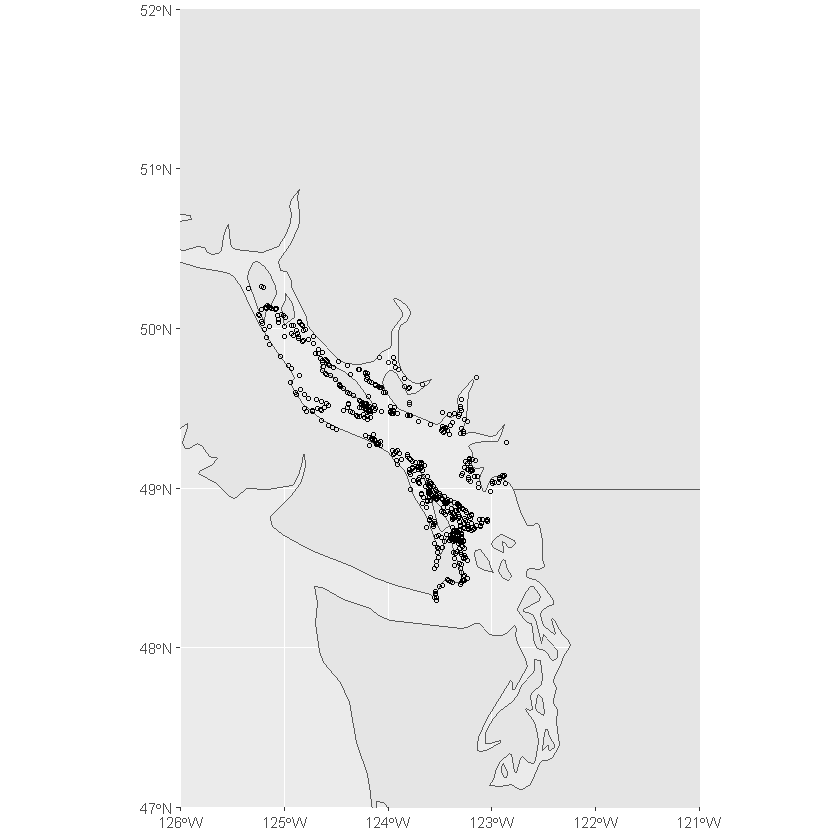

In [16]:
# fix the issues with positive longitudes
#hl_pts$Longitude[hl_pts$Longitude > 0] <- #hl_pts$Longitude[hl_pts$Longitude > 0] * -1
#plot(hl_pts$Longitude, hl_pts$Latitude)

# fix issues with some points in wrong hemisphere
hl_df2 <- hl_df_wrangled %>% mutate(Longitude = 
                               ifelse(Longitude>0, -Longitude, Longitude )
)

# create spatial pts object in lat / lon (sf R library)
hl_pts3 <- hl_df2 %>%
  st_as_sf(coords = c("Longitude", "Latitude"), crs = 4326)

#SpatialPointsDataFrame
# tried this, but didn't work
#hl_pts2 <- SpatialPointsDataFrame(coords=hl_pts$geometry,data=hl_pts)

# reproject to BC Albers
hl_pts_4326 <- hl_pts3 %>% st_set_crs(NA) %>% st_set_crs(4326)
hl_pts_3005 <- hl_pts_4326 %>% st_transform(3005)
#hl_pts_3005

#plot the points
world <- ne_countries(scale = "medium", returnclass = "sf")
ggplot(data = world) +
    geom_sf() +
    geom_sf(data = hl_pts_3005, size = 1, shape = 1, color=alpha("black",0.9)) + 
coord_sf(xlim = c(-121, -126), ylim = c(47, 52), expand = FALSE) #coord_sf(xlim = c(100, 140), ylim = c(45, 55), expand = FALSE)

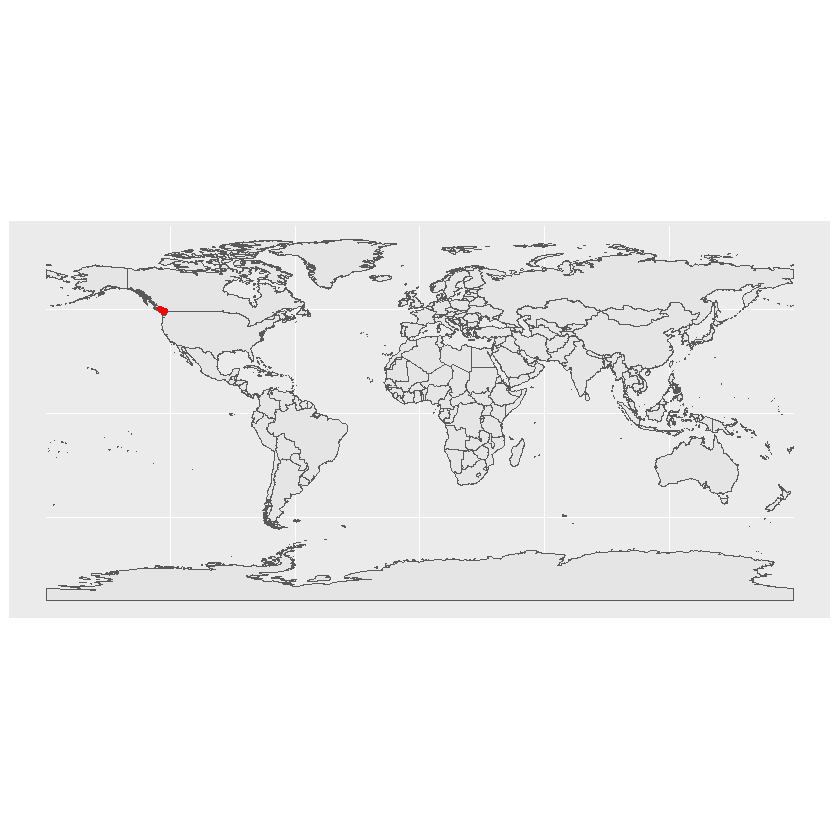

In [17]:
#global view to check no points are way off
world <- ne_countries(scale = "medium", returnclass = "sf")
ggplot(data = world) +
    geom_sf() +
    geom_sf(data = hl_pts_3005, size = 1, shape = 1, color=alpha("red",0.9))

In [ ]:
# see Etten (2014) for example
# create a raster from the Ecospace ASC
# create transition matrix with raster
# get nearesr marine cell row / col of ecospace map for each haulout


# issue: our grid is rotated and gdistance might be making distance 
#        corrections assuming not rotated. 

class      : RasterLayer 
dimensions : 151, 93, 14043  (nrow, ncol, ncell)
resolution : 0.01417672, 0.01169338  (x, y)
extent     : -124.5881, -123.2697, 48.54895, 50.31465  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0 
source     : memory
names      : layer 
values     : 0, 428  (min, max)


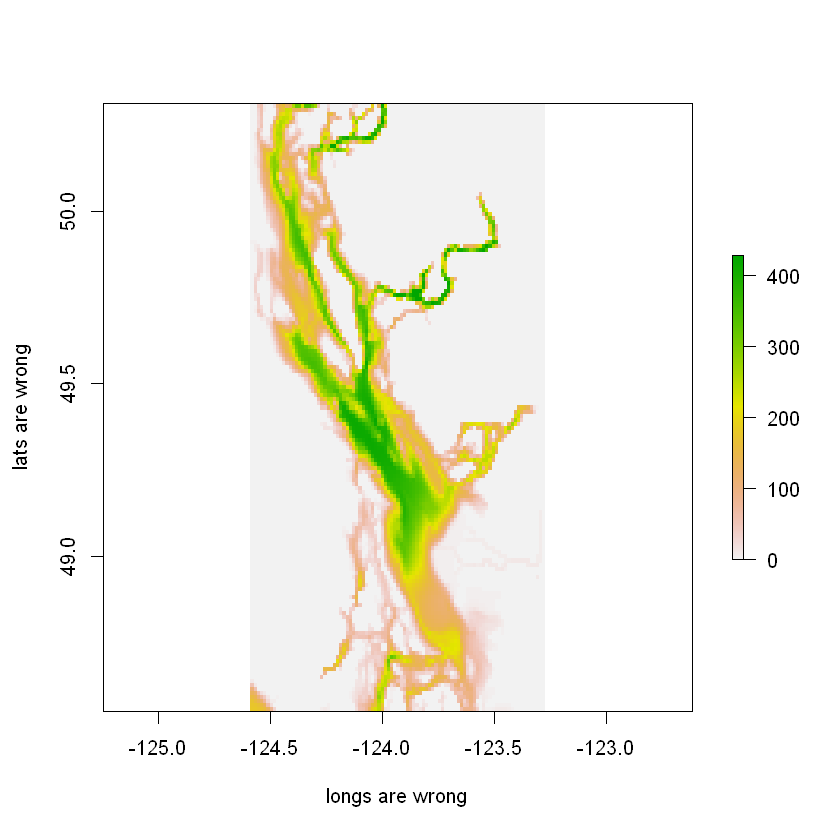

In [88]:
# read ecospace raster
ecospace_file = "C:/Users/Greig/Documents/GitHub/Ecosystem-Model-Data-Framework/data/basemap/ecospacedepthgrid.asc"
con = file(ecospace_file, "r")
i = 0

df1 <- read.table(ecospace_file, skip = 6, header = FALSE, sep = "")
r_mat <- data.matrix(df1)
# the values below determine the resolution using rows / cols. 
# because of the rotation I have chosen max and min from mid-points of rotated rectangular map
r <- raster(r_mat,
            xmn=-124.588135,
            xmx=-123.2697,
            ymn=48.54895,
            ymx=50.314651,
            crs=CRS("+proj=longlat +datum=WGS84"))
r
plot(r, xlab="longs are wrong", ylab="lats are wrong") 

In [89]:
#calculate conductances hence 1/max(x)
trans <- gdistance::transition(r, function(x) 1 / max(x), directions = 16)

### Get basemap from bathymetry and fix issues
#### check projections

class      : RasterLayer 
dimensions : 299, 132, 39468  (nrow, ncol, ncell)
resolution : 2.274809, 1  (x, y)
extent     : -0.1374046, 300.1374, 0.5, 299.5  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0 
source     : memory
names      : Bathymetry 
values     : 1, 10000  (min, max)


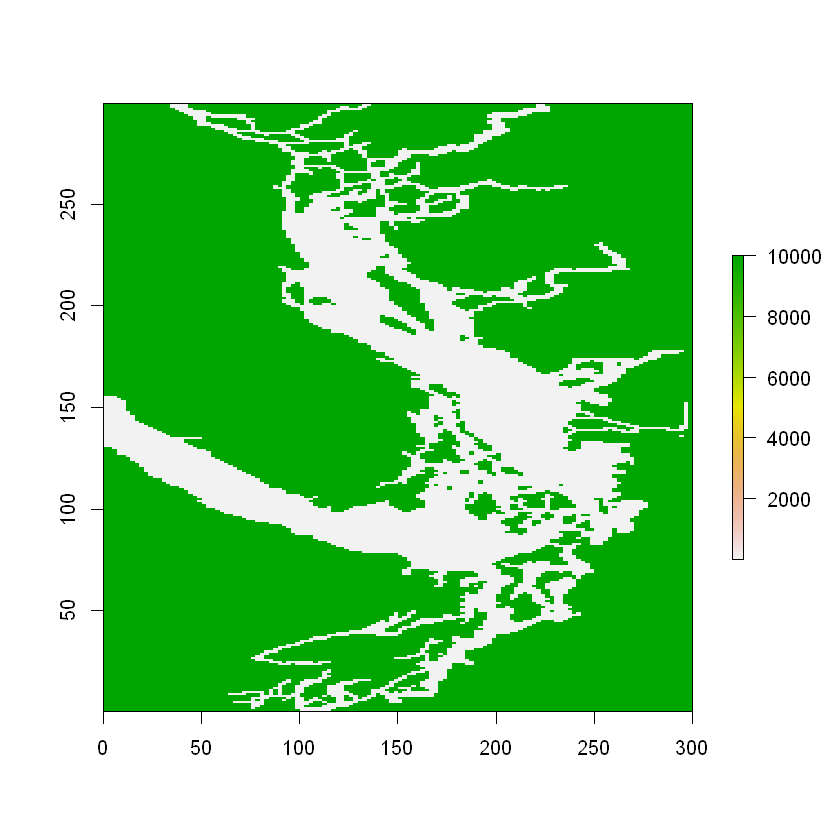

In [46]:
# get the haulouts as geopackage (can also read shapefiles)
#file_pts="temp/Haulouts.gpkg"
#file_pts="temp/Haulouts1974.gpkg"
#lyr="Haulouts"
#lyr="Haulouts1974"
#pnts <- readOGR(dsn=file_pts, layer=lyr)

# did not use the 'costrastergen' function from ipdw
# given that I already have a grid that's easy enough to use
#pols <- readOGR(dsn="BCLand.shp.gpkg")
# this doesn't work (takes forever)
#costras <- costrasterGen(pnts, pols, extent = "pnts",projstr = projection(pols))

# Get bathymetry as .nc file and check
ncfname <- paste(ncpath, ncname, ".nc", sep="")
bathync <- nc_open(ncfname)
#print(bathync)

# read the netcdf file as raster and create a copy to fiddle with
tmpin <- raster(ncfname,
                varname = "Bathymetry",
                xmn=min("nav_lon"),
                xmx=max("nav_lon"),
                ymn=min("nav_lat"),
                ymx=max("nav_lat"),
                crs=CRS("+proj=longlat +datum=WGS84"))
#tmpin
x <- tmpin

# change the NA values to the raster to 10000 as a high 'cost'
x[is.na(x[])] <- 10000
# change all other values to 1
x[x != 10000] <- 1

x
plot(x)

In [48]:

# check projection
crsBath <- projection(x)
print("CRS of bathymetry:")
crsBath

# check projection
#crsPts <- projection(hl_pts)
#crsPts
#crs_aea ="+proj=aea +lat_1=50 +lat_2=58.5 +lat_0=45 +lon_0=-126 +x_0=1000000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

# the raster and pnts are unprojected (geo wgs84) 
# convert to albers equal area
#s <- spTransform(hl_pts,crs_aea)
#s

# I'm not sure this works! Won't display on map if I do so. 
# May just be 'declaring projection'
x2 <- projectRaster(x,crs=crs_aea)
#x2 <- projectRaster(x,crs=3005)
x2

[1] "CRS of bathymetry:"


[1] "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"

ERROR: Error in rgdal::rawTransform(projfrom, projto, nrow(xy), xy[, 1], xy[, : STRING_ELT() can only be applied to a 'character vector', not a 'logical'


In [40]:
x2

ERROR: Error in eval(expr, envir, enclos): object 'x2' not found


In [18]:






#plot(x2, main="Salish Sea")
#points(hl_pts_3005)

# I got the crs projection info for aea from a geopackage
#pols <- readOGR(dsn="temp/BCLand.shp.gpkg")
#crsPols <- projection(pols)
#crsPols

Error in R_nc4_open: No such file or directory


ERROR: Error in nc_open(ncfname): Error in nc_open trying to open file ../../Bathy/From GETM/ORIGINAL/Bathymetry_500m.nc


#### Prep Map Plot Display Libraries etc

In [31]:
# Custom function to help display raster on map
#
# this function is custom from here: 
# https://stackoverflow.com/questions/48955504/how-to-overlay-a-transparent-raster-on-ggmap
# 
#' Transform raster as data.frame to be later used with ggplot
#' Modified from rasterVis::gplot
#'
#' @param x A Raster* object
#' @param maxpixels Maximum number of pixels to use
#'
#' @details rasterVis::gplot is nice to plot a raster in a ggplot but
#' if you want to plot different rasters on the same plot, you are stuck.
#' If you want to add other information or transform your raster as a
#' category raster, you can not do it. With `SDMSelect::gplot_data`, you retrieve your
#' raster as a data.frame that can be modified as wanted using `dplyr` and
#' then plot in `ggplot` using `geom_tile`.
#' If Raster has levels, they will be joined to the final tibble.
#'
#' @export

gplot_data <- function(x, maxpixels = 1000000)  {
  x <- raster::sampleRegular(x, maxpixels, asRaster = TRUE)
  coords <- raster::xyFromCell(x, seq_len(raster::ncell(x)))
  ## Extract values
  dat <- utils::stack(as.data.frame(raster::getValues(x)))
  names(dat) <- c('value', 'variable')

  dat <- dplyr::as.tbl(data.frame(coords, dat))

  if (!is.null(levels(x))) {
    dat <- dplyr::left_join(dat, levels(x)[[1]],
                            by = c("value" = "ID"))
  }
  dat
}

#### NOTE: the above code 'maxpixels' arg will simplify the raster and make it appear low res if it's set low

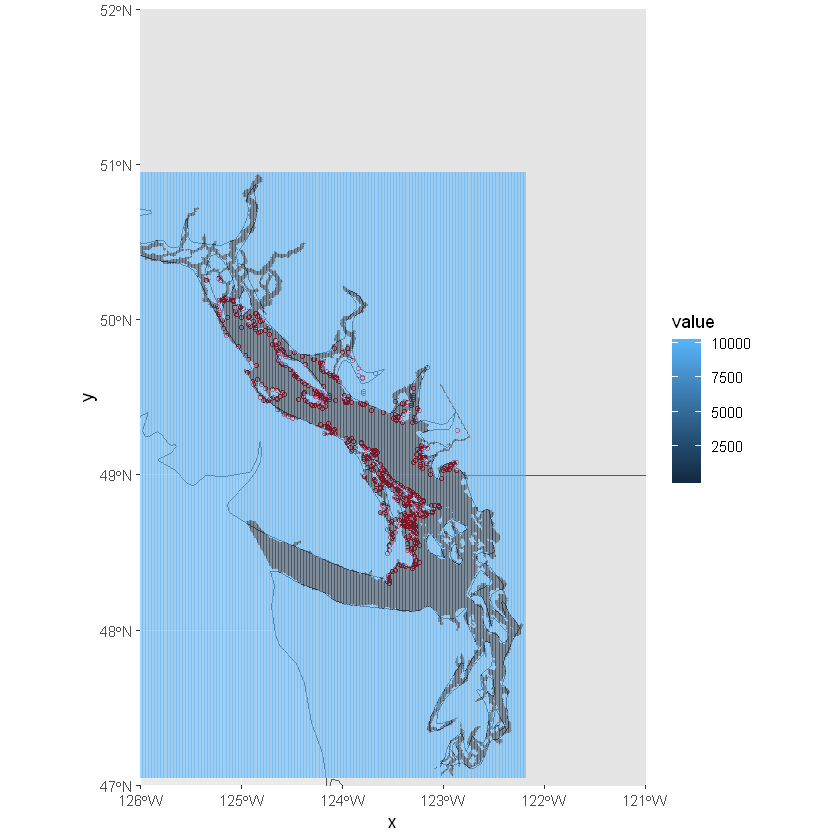

In [32]:
# transform raster to data frame for map display
# (does not work if using gplot_data with x2, the attemped CRS 3005 raster)
ss_ras_df <- gplot_data(x)

world <- ne_countries(scale = "medium", returnclass = "sf")
ggplot(data = world) +
    geom_sf() +
    geom_sf(data = hl_pts_3005, size = 1, shape = 1, color=alpha("red",0.9)) + 
  geom_tile(data = ss_ras_df, 
            aes(x = x, y = y, fill = value), alpha=0.5) +
    coord_sf(xlim = c(-121, -126), ylim = c(47, 52), expand = FALSE) #coord_sf(xlim = c(100, 140), ylim = c(45, 55), expand = FALSE)

### Re-Project Bathymetry

In [33]:
# must work with certain data types and projections
# reproject original raster
crs_aea ="+proj=aea +lat_1=50 +lat_2=58.5 +lat_0=45 +lon_0=-126 +x_0=1000000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
x2 <- projectRaster(x,crs=crs_aea)

crsBathx <- projection(x)
print("CRS bathymetry before:")
crsBathx

crsBathx2 <- projection(x2)
print("CRS bathymetry after:")
crsBathx2


crsBathPts <- projection(hl_pts_3005)
print("CRS haulouts before:")
crsBathPts

#reproject original points
#s <- spTransform(hl_pts3,crs_aea)
#s

#crsBathxPts2 <- projection(s)
#print("CRS haulouts after:")
#crsBathPts2

[1] "CRS bathymetry before:"


[1] "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"

[1] "CRS bathymetry after:"


[1] "+proj=aea +lat_1=50 +lat_2=58.5 +lat_0=45 +lon_0=-126 +x_0=1000000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

[1] "CRS haulouts before:"


[1] "+proj=aea +lat_1=50 +lat_2=58.5 +lat_0=45 +lon_0=-126 +x_0=1000000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

### Set raster cells with haulouts as 'water'

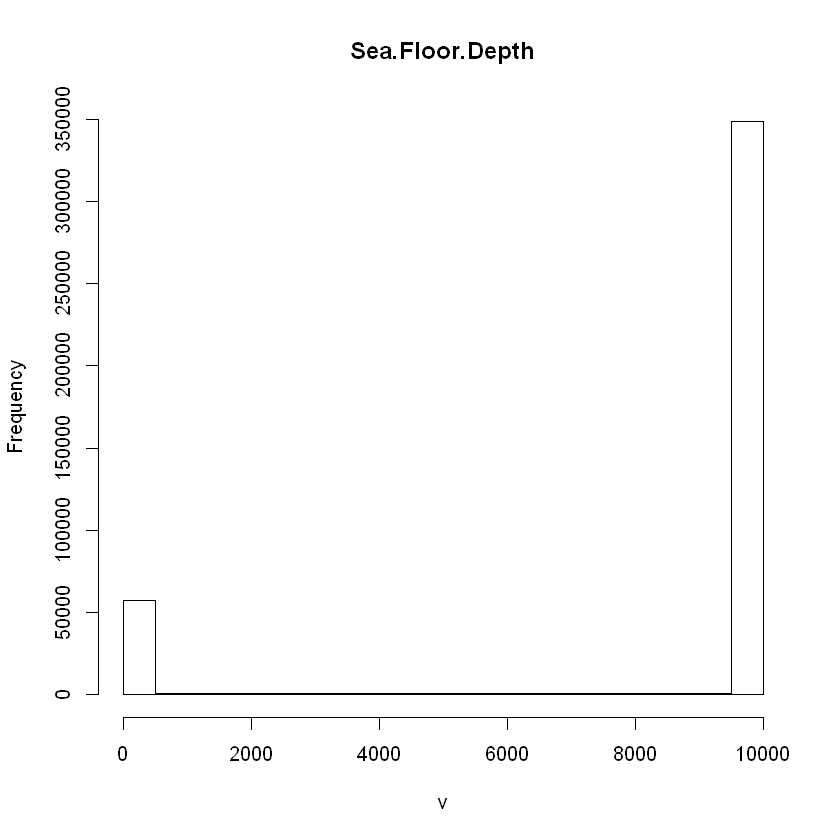

In [34]:
# check that costs of travel across map are either 10,000 (land) or 1 (water)
hist(x2)

#### Fix issues due to reprojection process

In [35]:
s1 <- hl_pts_3005

#s1@data["count"] <- 1 #for testing
#s1@data

# set 'cost' to 1 for all cells with a haulout
# need further edits to ensure seals can make it out of landlocked cells
ii <- raster::extract(x2, s1, cellnumbers=TRUE)[,"cells"]
x2[ii] <- 1

# problem fix: 
# - the unique values of x2 are not 1 and 10000 anymore due to reprojection process
x2[x2 < 5000] <- 1
x2[x2 >= 5000] <- 10000


#### Exported raster and haulout points to QGIS, created points to connect some haulouts to water

In [36]:
# fix haulout raster cells that are still landlocks
# (in some cases, the haulout locations are landlocked by more than one cell)
# I manually created this list using QGIS
raster::writeRaster(x2,filename = "tmp_costraster",format="GTiff", overwrite = TRUE, NAflag = -9999)  

# filter only unique haulout locations
s2 <- hl_pts_3005 %>% distinct(Site.Key, .keep_all = TRUE)
st_write(s2, "tmp_haulouts.shp", delete_layer = TRUE) # overwrites

Warning message in abbreviate_shapefile_names(obj):
"Field names abbreviated for ESRI Shapefile driver"

Deleting layer `tmp_haulouts' using driver `ESRI Shapefile'


Warning message in CPL_write_ogr(obj, dsn, layer, driver, as.character(dataset_options), :
"GDAL Error 4: Unable to open tmp_haulouts.shx or tmp_haulouts.SHX.Try --config SHAPE_RESTORE_SHX true to restore or create it"Warning message in CPL_write_ogr(obj, dsn, layer, driver, as.character(dataset_options), :
"GDAL Error 1: tmp_haulouts.shp is not a directory."

Creating dataset tmp_haulouts.shp failed.


ERROR: Error in CPL_write_ogr(obj, dsn, layer, driver, as.character(dataset_options), : Creation failed.



#### Import the points representing paths to water and apply to cost raster

In [37]:
# read the 'paths to water' point shapefile, created manually in QGIS
# use points to set cost raster values to '1'
pathsFix_df <- read.csv("PathsToWater.csv")
# create spatial pts object in lat / lon (sf R library)
pathsFix_df2 <- pathsFix_df %>% st_as_sf(coords = c("X", "Y"), crs = 4326)

# reproject to BC Albers
pathsFix_4326 <- pathsFix_df2 %>% st_set_crs(NA) %>% st_set_crs(4326)
pathsFix_3005 <- pathsFix_4326 %>% st_transform(3005)

# set 'cost' to 1 for all cells with a haulout
# need further edits to ensure seals can make it out of landlocked cells
ii <- raster::extract(x2, pathsFix_3005, cellnumbers=TRUE)[,"cells"]
x2[ii] <- 1

#### Check that costs are still 10000 (land) or 1 (water)

In [38]:
unique(x2)

[1]     1 10000

### 3) Interpolation
##### Transition matrix
 <a class="anchor" id="section-3"></a>
[BACK TO TOP](#top)

In [39]:
# below drawn from ipdw source code
# https://github.com/jsta/ipdw/blob/master/R/pathdistGen.R

# (1) calculates the cost to get anywhere from a point on the map
# RANGE = Maximum Foraging Distance (in bathy raster / map units of meters)
range = 40000 
costras = x2
spdf = s1
ipdw_range <- range / raster::res(costras)[1] # range in map units
# note the cells are not perfectly 500 m, so the ipdw_range is not as expected
  
#start interpolation
#calculate conductances hence 1/max(x)
trans <- gdistance::transition(costras, function(x) 1 / max(x), directions = 16)
# (note - GLO - low conductances = high cost of travel)

# NOTES - GLO
# in transition, users define a function f(i,j) to calculate the transition value for each pair of adjacent cells 
# i and j" (quoting from https://cran.r-project.org/web/packages/gdistance/vignettes/gdistance1.pdf)
# also see https://gis.stackexchange.com/questions/280593/understanding-the-values-from-transition-layers-produced-by-the-r-package-gdist

In [220]:
# OLD CODE 

# problem is haulouts object is 'sf' and I need 'spdf'
#  - https://gis.stackexchange.com/questions/239118/r-convert-sf-object-back-to-spatialpolygonsdataframe

#haulouts@data$Count

#spdf$Count2 <- (as.numeric(as.character(spdf$Count)))
#haulouts <- as(spdf,"Spatial")
#haulouts <- (haulouts["Count2"])
#haulouts <- haulouts[2,]
#haulouts

#seals = as.numeric(as.character(haulouts$Count))
#seals
#haulouts["Count"] <- as.numeric(as.character(haulouts@data$Count))


In [221]:
#paramlist <- c("Count2")
#final.ipdw <- ipdw(haulouts, costras, range = range, paramlist,
                                   #  overlapped = TRUE)
#pathdistanceraster <- pathdistGen(haulouts, costras, range, yearmon = "default", progressbar = TRUE)
#raster::writeRaster(pathdistanceraster,filename = "tmp_pathdist",format="GTiff", overwrite = TRUE, NAflag = -9999) 

In [40]:
ipdw_range

[1] 72.85974

In [19]:
# plot the transitionlayer
#plot(raster(trans))

# NOTE - GLO
# Not meant to be visualized as it is a multidimensional matrix
# transitionlayers when converted to raster are essentially averaging 
# the cost to all adjacent cells, for each cell

## 5) Test interpolation method 

In [110]:
# TEST - create cost surface for a point
#    spdf needs to be sf
coord <- st_coordinates(spdf[1,])
costsurf <- gdistance::accCost(trans, coord)

#    added by GLO to set to NA any cells outside the range
costsurf <- calc(costsurf, fun=function(x){ x[x > ipdw_range] <- NA; return(x)} )

In [111]:
#raster::writeRaster(trans,filename = "tmp_transrast",format="GTiff", overwrite = TRUE, NAflag = -9999)  
raster::writeRaster(costsurf,filename = "tmp_costsurf",format="GTiff", overwrite = TRUE, NAflag = -9999)  
#raster::writeRaster(x2,filename = "tmp_costras",format="GTiff", overwrite = TRUE, NAflag = -9999)

### Tests - plot and ggplot of one seal haulout distance / cost surface

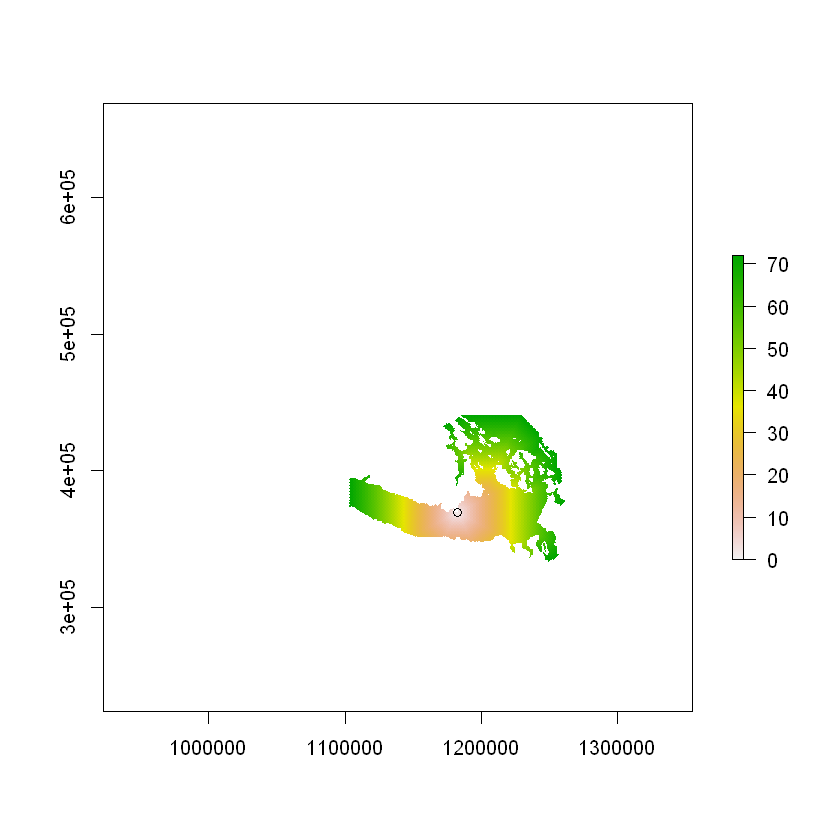

In [112]:
plot(costsurf)
points(st_coordinates(spdf[1,]))

#### Visualize using ggplot library 

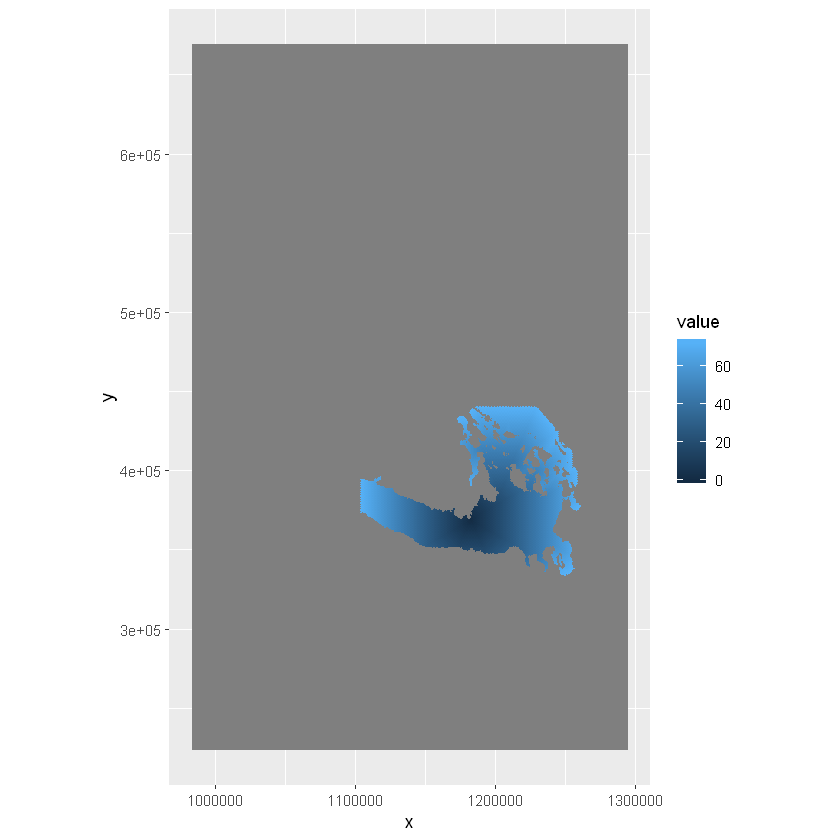

In [113]:
ss_ras_costsurf <- gplot_data(costsurf)

ggplot() +
geom_raster(data = ss_ras_costsurf,
    aes(x = x, y = y,
    fill = value)) +
coord_quickmap()

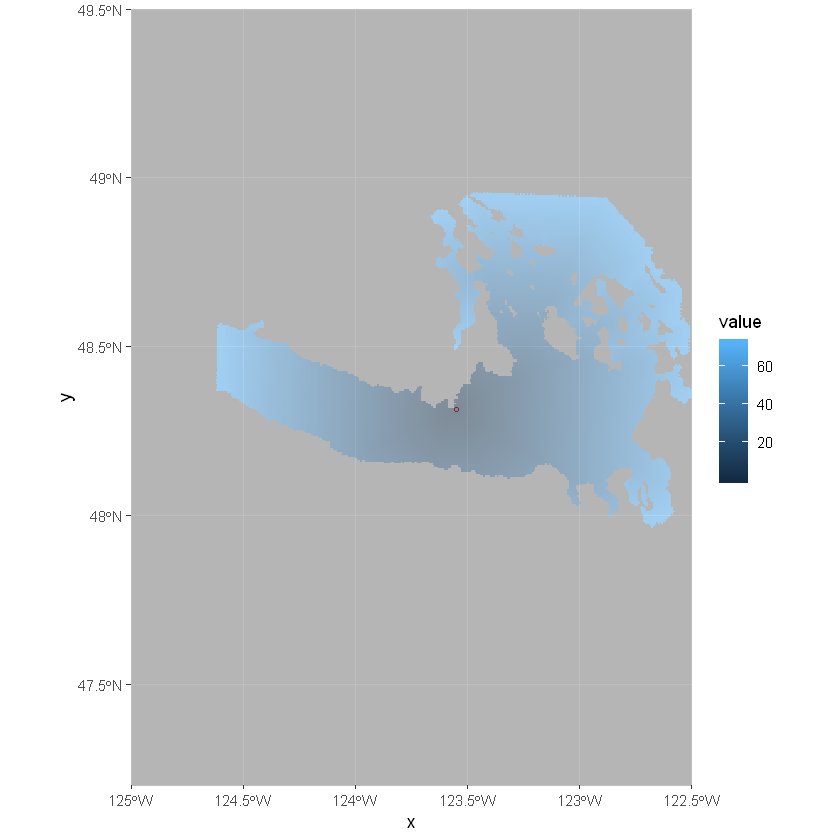

In [118]:
# reproject raster for display
# NOTE - GLO - 
#" it is generally not a good idea to use projectRaster with a crs= argument. 
# It is better to provide a Raster* object as template to project to"
# https://stackoverflow.com/questions/51137838/raster-projection-to-utm-to-lat-lon-in-r
# https://spatialreference.org/ref/epsg/3005/proj4/
#
costsurf_4326 <- projectRaster(costsurf,x)

# transform raster to data frame for map display
# (does not work if using gplot_data with x2, the attemped CRS 3005 raster)
ss_ras_costsurf <- gplot_data(costsurf_4326)

ggplot(data = world) +
    geom_sf(data = spdf[1,], size = 1, shape = 1, color=alpha("red",0.9)) + 
    geom_tile(data = ss_ras_costsurf, 
            aes(x = x, y = y, fill = value), alpha=0.5) +
    coord_sf(xlim = c(-125, -122.5), ylim = c(47.2, 49.5), expand = FALSE) #coord_sf(xlim = c(100, 140), ylim = c(45, 55), expand = FALSE)

In [114]:
x_ipdw <- 1/costsurf

# (5) # fix na's and infinite values
x_ipdw[is.infinite(x_ipdw[])] <- 1
x_ipdw[is.na(x_ipdw)] <- 0


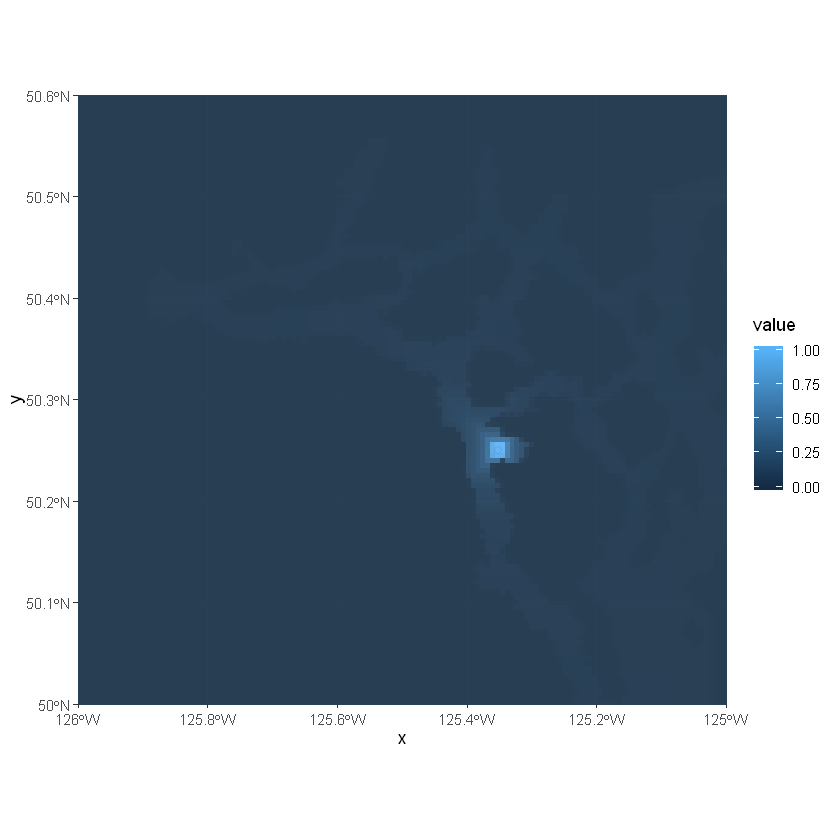

In [229]:
costsurf_4326 <- projectRaster(x_ipdw,x)

# transform raster to data frame for map display
# (does not work if using gplot_data with x2, the attemped CRS 3005 raster)
ss_ras_costsurf <- gplot_data(costsurf_4326)

ggplot(data = world) +
    geom_sf(data = spdf[1,], size = 2, shape = 1, color=alpha("red",1)) + 
    geom_tile(data = ss_ras_costsurf, 
            aes(x = x, y = y, fill = value), alpha=0.9) +
    coord_sf(xlim = c(-125, -126), ylim = c(50, 50.6), expand = FALSE) #coord_sf(xlim = c(100, 140), ylim = c(45, 55), expand = FALSE)

### Get Unique years to loop through

In [148]:
# get unique years (r language = year 'levels')
#y_unique <-unique(format(as.Date(spdf$Date.1, format="%Y-%m-%d"),"%Y"))
y_unique <-unique(format(spdf$Date.1))

# NOTE - GLO 
# https://stackoverflow.com/questions/24783860/loop-over-unique-values-r

#TEST
y = 0
#for (y in 1:length(y_unique)){
#    print(y_unique[y])
#}
sort(y_unique)

[1] "1966" "1967" "1968" "1969" "1970" "1971" "1972" "1973" "1974" "1975"
[11] "1976" "1977" "1978" "1979" "1980" "1981" "1982" "1983" "1984" "1985"
[21] "1986" "1987" "1988" "1989" "1990" "1991" "1992" "1993" "1994" "1995"
[31] "1996" "1997" "1998" "1999" "2000" "2001" "2002" "2003" "2004" "2005"
[41] "2006" "2007" "2008" "2009" "2010" "2011" "2012" "2013" "2014"

In [149]:
# get only data from one year
y = 5 # begins at index 1, not 0

# filter for desired year
#spdf_yr <- filter(spdf, format(as.Date(spdf$Date.1, format="%Y-%m-%d"),"%Y") == y_unique[y])
spdf_yr <- filter(spdf, spdf$Date.1 == y_unique[y])
head(spdf_yr)

Date.1,Site.Key,Location.Value,Location.Info,Date,Count,geometry
<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<POINT [m]>
1977,H0001,West Bentinck Island Reefs,South Gulf,NA,38.16667,POINT (1182114 369469.6)
1977,H0002,Race Rocks,South Gulf,NA,210.83333,POINT (1183602 367956.2)
1977,H0003,Haystock Islets,South Gulf,NA,41.50000,POINT (1185123 377157.1)
1977,H0004,Chain Islets,South Gulf,NA,121.87500,POINT (1202897 382277.6)
1977,H0005,Zero Rock,South Gulf,NA,18.62500,POINT (1200488 393601.3)
1977,H0006,South D'Arcy Island Reef,South Gulf,NA,1.87500,POINT (1201197 397526.9)


## 6) Main Code Loops

In [151]:
y_unique <- sort(y_unique)
y <- 1
for (y in 1:length(y_unique)){
    print(y_unique[y])
}


[1] "1966"
[1] "1967"
[1] "1968"
[1] "1969"
[1] "1970"
[1] "1971"
[1] "1972"
[1] "1973"
[1] "1974"
[1] "1975"
[1] "1976"
[1] "1977"
[1] "1978"
[1] "1979"
[1] "1980"
[1] "1981"
[1] "1982"
[1] "1983"
[1] "1984"
[1] "1985"
[1] "1986"
[1] "1987"
[1] "1988"
[1] "1989"
[1] "1990"
[1] "1991"
[1] "1992"
[1] "1993"
[1] "1994"
[1] "1995"
[1] "1996"
[1] "1997"
[1] "1998"
[1] "1999"
[1] "2000"
[1] "2001"
[1] "2002"
[1] "2003"
[1] "2004"
[1] "2005"
[1] "2006"
[1] "2007"
[1] "2008"
[1] "2009"
[1] "2010"
[1] "2011"
[1] "2012"
[1] "2013"
[1] "2014"


### Temp - only get some years (each year takes ~30 min)

In [80]:
y_unique = c("2000","2001","2002")

In [81]:
spdf_yr <- filter(spdf, Date.1 == y_unique[1])
spdf_yr

Date.1,Site.Key,Location.Value,Location.Info,Date,Count,geometry
<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<POINT [m]>
1998,H0001,West Bentinck Island Reefs,South Gulf,1998-09-06,173.000000,POINT (1182114 369469.6)
1998,H0002,Race Rocks,South Gulf,1998-09-06,359.000000,POINT (1183602 367956.2)
1998,H0003,Haystock Islets,South Gulf,1998-09-06,129.000000,POINT (1185123 377157.1)
1998,H0004,Chain Islets,South Gulf,1998-09-06,144.000000,POINT (1202897 382277.6)
1998,H0005,Zero Rock,South Gulf,1998-09-06,111.000000,POINT (1200488 393601.3)
1998,H0006,South D'Arcy Island Reef,South Gulf,1998-09-06,56.000000,POINT (1201197 397526.9)
1998,H0007,Unit Rocks,South Gulf,1998-09-06,91.000000,POINT (1202967 398061.7)
1998,H0008,Northwest Little D'Arcy Island Rock,South Gulf,NA,46.500000,POINT (1201825 399283.8)
1998,H0009,Sallas Rocks,South Gulf,1998-09-06,149.000000,POINT (1200339 400392.9)


In [ ]:
y <- 1

for (y in 1:length(y_unique)){
    spdf_yr <- filter(spdf, Date.1 == y_unique[y])


i <- 1 # haulout index

for(i in seq_len(nrow(spdf_yr))){
    coord <- st_coordinates(spdf_yr[i,])
    costsurf <- gdistance::accCost(trans, coord)

    # (2) calculates the maximum distance?
    #ipdw_dist <- raster::hist(costsurf, plot = FALSE)$breaks[2]
    #if(ipdw_dist < ipdw_range){
    #  ipdw_dist <- ipdw_range    
    #}

    # (2)
    # added by GLO to set to NA any cells outside the range
    costsurf <- calc(costsurf, fun=function(x){ x[x > ipdw_range] <- NA; return(x)} )

    # (3) reclassify cost surface (is it accessible under the range / limit)
    # problem - the upper class lumps all cells equal to max distance together
    #costsurf_reclass <- raster::reclassify(costsurf, 
    #                                       c(ipdw_dist, +Inf, NA,
    #                                         ipdw_range, #ipdw_dist, ipdw_range)) 

    # (4) make it inverse distance 
    #x_ipdw <- 1/costsurf^2
    #x_ipdw <- calc(costsurf, fun=function(x){ x[x > range] <- NA; return(x)} )
    x_ipdw <- 1/costsurf

# (5) # fix na's and inifinite values
    x_ipdw[is.infinite(x_ipdw[])] <- 1
    x_ipdw[is.na(x_ipdw)] <- 0

# (6)  Multiply each cell's idpw value by the haulout size
    
    # rescale each cell value out of 1 where 1 = total from all cells
    # each cell represents and then multiply by haulout size
    tot_val = cellStats(x_ipdw,sum)
    #seals = spdf[i,"count"]@data

    pts_count <- spdf_yr %>% as.data.frame 
    # https://stackoverflow.com/questions/34469178/r-convert-factor-to-numeric-and-remove-levels
    seals = as.numeric(as.character(pts_count$Count[i]))
    #seals = spdf[i,"Count"]@data

    var_f = tot_val*seals
    #var_f = tot_val*seals[1,]
    #print("seal count")
    #print(seals)
    #print("tot_val")
    #print(tot_val)
    #print("var_f")
    #print(var_f)
    #print("check 2")

    # each cell = % of total foraging arena (or probability of foraging)
    # weight by cell density at haulout
    x2_ipdw <- x_ipdw / tot_val * seals
    #x2_ipdw <- x_ipdw / tot_val * seals[1,]

    #print("check 3")

    #print(i)
    #print(paste("seals: ", seals))

# (7) Write to disk
    # (best practice is to write so not all rasters stored in RAM)
    raster::writeRaster(x2_ipdw,filename = file.path(tempdir(), paste(y_unique[y],"sealcount", "A1ras", i, ".grd", sep = "")), overwrite = TRUE, NAflag = -99999)
    #print("check 3")

} # end haulout loop

# (8) Open the temp rasters, create rasterstack (one for each haulout)

# get list of temp raster files
raster_flist <- list.files(path = file.path(tempdir()), pattern = paste("sealcount", "A1ras*", sep = ""), full.names = TRUE)
# filter to only get .grd files
raster_flist <- raster_flist[grep(".grd", raster_flist, fixed = TRUE)]

as.numeric(gsub('.*A1ras([0123456789]*)\\.grd$', '\\1', raster_flist)) -> fileNum # get raster by file

raster_flist <- raster_flist[order(fileNum)] # order them
rstack <- raster::stack(raster_flist)
rstack <- raster::reclassify(rstack, cbind(-99999, NA))

# delete temp rasters
file.remove(list.files(path = file.path(tempdir()),
                       pattern = paste("sealcount", "A1ras*", sep = ""), 
                       full.names = TRUE))

##(9) Combine the foraging intensity rasters for each haulout into one raster for all haulouts

# 'add' rasters.
# make sure NA is changed to zero
z <- rstack[[1]]
z[is.na(z[])] <- 0

for (i in 2:nlayers(rstack)){
  each_ras <- rstack[[i]]
  each_ras[is.na(each_ras[])] <- 0
  z <- z + each_ras
}

# rescale each cell value in similar fashion as step (6) 
# final result is each cell contains a multiplier (range 0 to 1)
# representing a relative foraging intensity
# can be used to multiple total biomass for SoG to get B per cell
tot_val = cellStats(z, sum)
final_sealrast <- z / tot_val

#raster::writeRaster(x2_ipdw,filename = file.path(tempdir(), paste(y_unique[y],"sealcount", "A1ras", i, ".grd", sep = "")), overwrite = TRUE, NAflag = -99999)
  
raster::writeRaster(final_sealrast,filename = paste("sealforagingintens",y_unique[y],".tiff", sep=""),format="GTiff", overwrite = TRUE, NAflag = -9999)
#raster::writeRaster(z,filename = paste("TMPsealforagingintens",y_unique[y],".tiff", sep=""),format="GTiff", overwrite = TRUE, NAflag = -9999)

print(paste("Finished year: ", y))
}# end year loop

In [78]:
# where intermediate files are written
tempdir()

[1] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpktilSH"

In [233]:
# should sum to 1
cellStats(final_sealrast,sum)

[1] 1

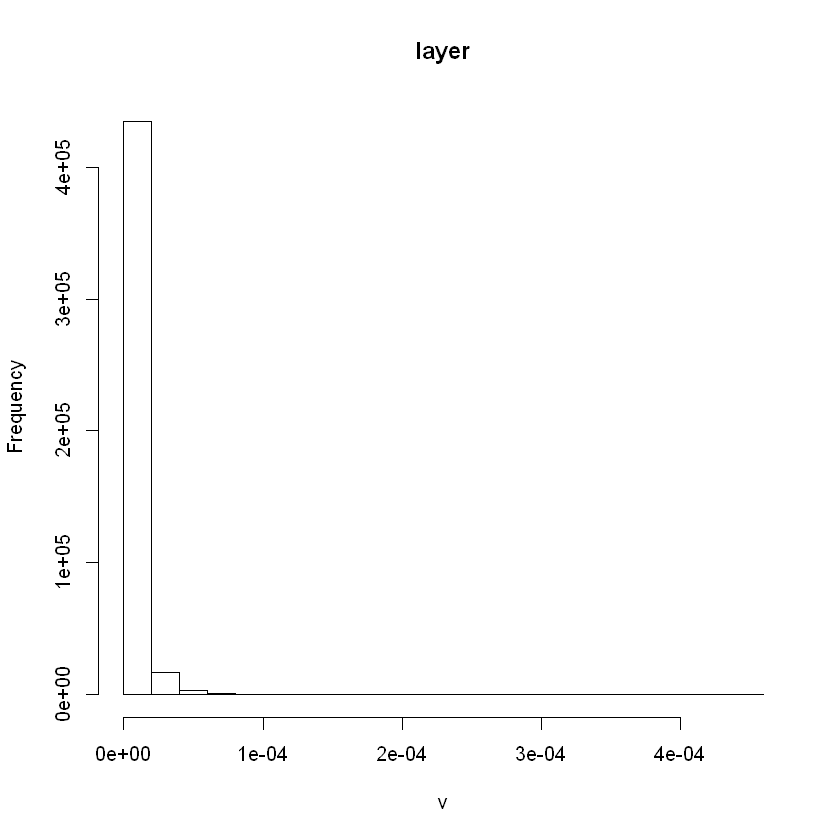

In [241]:
# helps with symbologization in qgis
hist(final_sealrast)

### Inspect Results

In [155]:
cellStats(z, sum)
cellStats(final_sealrast, sum)

[1] 2050

[1] 1

In [156]:
final_sealrast


class      : RasterLayer 
dimensions : 803, 568, 456104  (nrow, ncol, ncell)
resolution : 549, 555  (x, y)
extent     : 982848.8, 1294681, 223595.4, 669260.4  (xmin, xmax, ymin, ymax)
crs        : +proj=aea +lat_1=50 +lat_2=58.5 +lat_0=45 +lon_0=-126 +x_0=1000000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 
source     : memory
names      : layer 
values     : 0, 0.001333111  (min, max)


## 7) Multiply foraging intensity rasters by abundances
#### Create distribution map for animation creation, communication, display etc (not meant for Ecospace)

In [41]:
# get seal abundances from table
seal_abun <- read.csv("../Abundance_Nelsonetal2019/MODIFIED/seal_data.csv")
seal_abun_tib <- as.tibble(seal_abun)
seal_abun_tib

Warning message:
"`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session."

year,sog,ps,juan,coast,sog_density,ps_density,juan_density,coast_density
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1970,2973.089,1576.769,283.6796,506.3111,1.002390,0.7354332,1.260798,2.259006
1971,3153.407,1931.046,347.4183,625.1988,1.063185,0.9006744,1.544081,2.789447
1972,3344.660,2323.882,418.0943,759.8063,1.127667,1.0839002,1.858197,3.390025
1973,3545.886,2752.228,495.1588,909.8927,1.195511,1.2836884,2.200706,4.059665
1974,3865.871,3212.174,577.9085,1074.8777,1.303395,1.4982153,2.568482,4.795778
1975,4388.140,3699.150,665.5214,1253.8700,1.479481,1.7253497,2.957873,5.594387
1976,4978.878,4208.139,757.0946,1443.5300,1.678651,1.9627512,3.364865,6.440592
1977,5567.263,4733.879,851.6816,1663.3267,1.877027,2.2079660,3.785252,7.421259
1978,6226.638,4732.290,638.0100,1911.7486,2.099339,2.2072248,2.835600,8.529642


In [78]:
# get relative distribution raster
year1 = "1997"
mypath = "./"
#list.files(full.names = T)
intens_file <- paste("./sealforagingintens", year1, ".tif", sep="")
r <- raster(x = intens_file, package="raster")
#r

In [79]:
# get the abundance for year of interest
#for (i in 1:length(seal_abun_tib)){
#    print(seal_abun_tib$year[i])
#    print(seal_abun_tib$sog[i])
#}
abun_yr <- seal_abun_tib %>% 
    filter(year == year1)%>% 
    pull(sog)
abun_yr

# multiply raster cells by abundance
r2 <- r * abun_yr

# export new raster
raster::writeRaster(r2,filename = paste("sealforagingintensWeighted",year1,".tiff", sep=""),format="GTiff", overwrite = TRUE, NAflag = -9999)

[1] 36548.52

### Make a GeoTIFF

In [68]:
library(magick) # this is call to animate/read pngs
#library(purr) not available for 3.5

ERROR: Error in library(purr): there is no package called 'purr'


In [ ]:
filenames = ["sealforagingintensWeighted1976",
             "sealforagingintensWeighted1977",
             "sealforagingintensWeighted1978",
             "sealforagingintensWeighted1979",
             "sealforagingintensWeighted1980",
             "sealforagingintensWeighted1981",
             "sealforagingintensWeighted1982",
             "sealforagingintensWeighted1983",
             "sealforagingintensWeighted1984",
             "sealforagingintensWeighted1985",
             "sealforagingintensWeighted1986",
             "sealforagingintensWeighted1987",
             "sealforagingintensWeighted1988",
             "sealforagingintensWeighted1989",
             "sealforagingintensWeighted1990",
             "sealforagingintensWeighted1991",
             "sealforagingintensWeighted1992",
             "sealforagingintensWeighted1993",
             "sealforagingintensWeighted1994",
             "sealforagingintensWeighted1995",
             "sealforagingintensWeighted1996",
             "sealforagingintensWeighted1997",
             "sealforagingintensWeighted1998",
             "sealforagingintensWeighted1999",
             "sealforagingintensWeighted2000"]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('SealDist.gif', images)

In [ ]:
# Step 2: List those Plots, Read them in, and then make animation
list.files(path = "./fig_output/ndwi/", pattern = "*.png", full.names = T) %>% 
  map(image_read) %>% # reads each path file
  image_join() %>% # joins image
  image_animate(fps=2) %>% # animates, can opt for number of loops
  image_write("ndwi_aug_hgm.gif") # write to current dir